<a href="https://colab.research.google.com/github/chineidu/NLP-Tutorial/blob/main/notebook/Projects/Data-mining/02-sentiments-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis

- Using Qdrant

```sh
!pip install transformers[torch]
!pip install datasets evaluate
!pip install sentence-transformers qdrant-client


# Local Qdrant Instance
docker run -p 6333:6333 --rm --name vector_db \
    -v $(pwd)/qdrant_storage:/qdrant/storage \
    qdrant/qdrant
```

## Install Dependencies

In [1]:
!pip install transformers[torch]
!pip install datasets evaluate
!pip install sentence-transformers qdrant-client

zsh:1: no matches found: transformers[torch]


In [2]:
# Built-in library
import re
import json
from typing import Any, Optional, TypeAlias, Union
import logging
import warnings

# Standard imports
import numpy as np
from pathlib import Path
import pandas as pd
import polars as pl
from pprint import pprint
from rich import print
import torch

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

## Load And Prepare Dataset

- I'll be using a dataset containing approx. 90k hotel reviews by customers.
- The dataset can be loaded using HuggingFace datasets.

In [3]:
from datasets import load_dataset, Dataset


PATH: str = "ashraq/hotel-reviews"
reviews_data: Dataset = load_dataset(PATH, split="train")
reviews_data

Dataset({
    features: ['review_date', 'hotel_name', 'review'],
    num_rows: 93757
})

In [4]:
RANDOM_STATE: int = 123

print(reviews_data[:3])

{
    'review_date': ['8/3/2017', '8/3/2017', '8/3/2017'],
    'hotel_name': [
        'Park Plaza County Hall London',
        'Park Plaza County Hall London',
        'Park Plaza County Hall London'
    ],
    'review': [
        ' Extra bed was the worst breakfast queue was really terrible It s easy to tell people to come at a 
specific time though you have to arrange it somehow Parking is far away and hard to come back because of road 
diversions ',
        ' Just the location and view',
        ' Around the corner from the London eye and used it for a Trafalgar trip as the pickup for our tour was 
around the corner Walked down to the Borough market and took a river cruise to Greenwich Plent of eating spots 
close by as well Over the bridge was Westminster Abbey Parliament House and Big Ben and walked to Trafalgar Square 
as well also a laundry available which is very helpful '
    ]
}

In [5]:
# Convert to tabular data
df: pd.DataFrame = reviews_data.to_pandas()

df_pl: pl.DataFrame = pl.from_pandas(data=df)
df_pl

review_date,hotel_name,review
str,str,str
"""8/3/2017""","""Park Plaza Cou…",""" Extra bed was…"
"""8/3/2017""","""Park Plaza Cou…",""" Just the loca…"
"""8/3/2017""","""Park Plaza Cou…",""" Around the co…"
"""8/2/2017""","""Park Plaza Cou…",""" I wish you ha…"
"""8/2/2017""","""Park Plaza Cou…",""" You re always…"
"""8/2/2017""","""Park Plaza Cou…",""" Bit of a wait…"
"""8/2/2017""","""Park Plaza Cou…",""" The staff wer…"
"""8/2/2017""","""Park Plaza Cou…",""" Housekeeping …"
"""8/2/2017""","""Park Plaza Cou…",""" The location …"


```python
# Convert back to HF dataset
reviews_data_1: Dataset = Dataset.from_pandas(df=df_pl.to_pandas())
reviews_data_1
```

## Initialize Sentiment Analysis Model

- I'll be using a finetuned [RoBERTa](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest?text=This+hotel+is+not+so+great.+It+lacks+basic+facilities.) model.

- The `label2id` is obtained from the `model card` on Huggingface.

In [6]:
# Set up the labels. The model label is obtained form the model card
label2id: dict[str, Any] = {"negative": 0, "neutral": 1, "positive": 2}
id2label: dict[str, Any] = {_id: _label for _label, _id in label2id.items()}

print(f"label2id: {label2id}")
print(f"id2label: {id2label}")

label2id: {'negative': 0, 'neutral': 1, 'positive': 2}

id2label: {0: 'negative', 1: 'neutral', 2: 'positive'}

In [7]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline,
)


MODEL_CHECKPOINT: str = "cardiffnlp/twitter-roberta-base-sentiment-latest"
TASK: str = "sentiment-analysis"

# Load the model from HuggingFace Hub
# Add the label mappings
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT,
    id2label=id2label,
    label2id=label2id,
)

# Load the tokenizer from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

2023-11-29 06:01:54.319762: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequ

In [8]:
# Check if GPU is available
device: str = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

Device: cpu

In [9]:
# Setup the classifier pipeline
clf = pipeline(task=TASK, model=model, device=device, tokenizer=tokenizer)

In [10]:
# Test the classifier pipeline
text: str = reviews_data[250].get("review")

print(text)

Everything was perfect especially the Italian restaurant where the food was outstanding Everyone were extremely 
nice and helpful and I mean everyone

In [11]:
# Get the sentiments
clf(text)

[{'label': 'positive', 'score': 0.9884264469146729}]

<br><hr>

## Initialize Retriever

- **Retriever**:
  - In NLP, a `retriever` is a component that identifies and retrieves relevant documents or passages from a large corpus of text.

- Applications:
  - Question answering
  - Information retrieval
  - Text summarization

- `Sentence-transformer` model will be used as the `retriever`.

- I'll be using [all-MiniLM-L6-v2](sentence-transformers/all-MiniLM-L6-v2) retrieval because of its small size (***~90 mb***).
- For higher accuracy, you can use a more powerful transformer like [all-mpnet-base-v2](sentence-transformers/all-mpnet-base-v2).

In [12]:
from sentence_transformers import SentenceTransformer


ENCODER_CHECKPOINT: str = "sentence-transformers/all-MiniLM-L6-v2"
# Load the model from HuggingFace Hub
encoder = SentenceTransformer(ENCODER_CHECKPOINT, device=device)

encoder

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [13]:
encoder.get_max_seq_length(), encoder.get_sentence_embedding_dimension()

(256, 384)

### Initialize Qdrant Collection (Index)

- I'll be using [Qdrant](https://qdrant.tech/) as the vector DB.
- The vector dimension is `384` which was obtained by running:

```python
encoder.get_sentence_embedding_dimension()
# Returns: 384
```
- The metric used is `cosine` similarity.

In [14]:
from qdrant_client import QdrantClient, models
from qdrant_client.http.exceptions import UnexpectedResponse


URL: str = "http://localhost:6333"
client = QdrantClient(URL)
DIMENSION: int = encoder.get_sentence_embedding_dimension()
METRIC: Any = models.Distance.COSINE
COLLECTION_NAME: str = "sentiment-analysis"

# Create a collection
try:
    client.create_collection(
        collection_name=COLLECTION_NAME,
        vectors_config=models.VectorParams(
            size=encoder.get_sentence_embedding_dimension(),  # Vector size is defined by used model
            distance=METRIC,
        ),
    )
# if collection already exists
except UnexpectedResponse as err:
    print(err)

In [15]:
# Get collection details
collection_info: Any = client.get_collection(collection_name=COLLECTION_NAME)
print(collection_info)

CollectionInfo(
    status=<CollectionStatus.GREEN: 'green'>,
    optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>,
    vectors_count=0,
    indexed_vectors_count=0,
    points_count=0,
    segments_count=6,
    config=CollectionConfig(
        params=CollectionParams(
            vectors=VectorParams(
                size=384,
                distance=<Distance.COSINE: 'Cosine'>,
                hnsw_config=None,
                quantization_config=None,
                on_disk=None
            ),
            shard_number=1,
            replication_factor=1,
            write_consistency_factor=1,
            read_fan_out_factor=None,
            on_disk_payload=True
        ),
        hnsw_config=HnswConfig(
            m=16,
            ef_construct=100,
            full_scan_threshold=10000,
            max_indexing_threads=0,
            on_disk=False,
            payload_m=None
        ),
        optimizer_config=OptimizersConfig(
            deleted_threshold=0.2,
            vacuum_min_vector_number=1000,
            default_segment_number=0,
            max_segment_size=None,
            memmap_threshold=None,
            indexing_threshold=20000,
            flush_interval_sec=5,
            max_optimization_threads=1
        ),
        wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0),
        quantization_config=None
    ),
    payload_schema={}
)

### Generate Embeddings

- Generate embeddings for all the reviews in the dataset.
- The embeddings, the sentiment label and score will be included in the Pinecone index as metadata.
- The metadata will be used to understand the customer opinions.

In [16]:
def get_sentiment(reviews: list[str]) -> list[list[str], list[float]]:
    """This is used to obtain the label and the corresponding score."""
    result: list[dict[str, Any]] = clf(reviews)
    label: list[str] = [x.get("label") for x in result]
    score: list[str] = [x.get("score") for x in result]
    return (label, score)

In [17]:
print(df_pl.head())

shape: (5, 3)
┌─────────────┬───────────────────────────────┬───────────────────────────────────┐
│ review_date ┆ hotel_name                    ┆ review                            │
│ ---         ┆ ---                           ┆ ---                               │
│ str         ┆ str                           ┆ str                               │
╞═════════════╪═══════════════════════════════╪═══════════════════════════════════╡
│ 8/3/2017    ┆ Park Plaza County Hall London ┆  Extra bed was the worst breakfa… │
│ 8/3/2017    ┆ Park Plaza County Hall London ┆  Just the location and view       │
│ 8/3/2017    ┆ Park Plaza County Hall London ┆  Around the corner from the Lond… │
│ 8/2/2017    ┆ Park Plaza County Hall London ┆  I wish you had wheat free snack… │
│ 8/2/2017    ┆ Park Plaza County Hall London ┆  You re always my hotel of choic… │
└─────────────┴───────────────────────────────┴───────────────────────────────────┘

In [18]:
# Convert df -> series -> list
sample: pl.Series = df_pl.select(pl.col("review"))[:3].to_series().to_list()
print(sample)

[
    ' Extra bed was the worst breakfast queue was really terrible It s easy to tell people to come at a specific 
time though you have to arrange it somehow Parking is far away and hard to come back because of road diversions ',
    ' Just the location and view',
    ' Around the corner from the London eye and used it for a Trafalgar trip as the pickup for our tour was around 
the corner Walked down to the Borough market and took a river cruise to Greenwich Plent of eating spots close by as
well Over the bridge was Westminster Abbey Parliament House and Big Ben and walked to Trafalgar Square as well also
a laundry available which is very helpful '
]

In [19]:
# Get the sentiments of the 3 sample reviews
get_sentiment(reviews=sample)

(['negative', 'neutral', 'neutral'],
 [0.9103229641914368, 0.7918538451194763, 0.566495954990387])

### To Do

- Convert the review dates to timestamp which can be used to filter query results for a given period.
- This is helpful to understand customer sentiment over a specific period.

In [20]:
def format_dates(dates: list[str]) -> list[str]:
    """This is used to format the dates."""
    from datetime import datetime

    _format: str = "%m/%d/%Y"
    formatted_dates: list[str] = [
        f"{datetime.strptime(str_d, _format).date()}" for str_d in dates
    ]
    return formatted_dates


def format_date(str_date: str) -> str:
    """This is used to format a `single` date value."""
    from datetime import datetime

    _format: str = "%m/%d/%Y"
    formatted_date: str = f"{datetime.strptime(str_date, _format).date()}"

    return formatted_date

In [21]:
assert format_dates(dates=["04/14/2016", "04/29/2020"]) == ["2016-04-14", "2020-04-29"]

assert format_date(str_date="04/14/2016") == "2016-04-14"

In [22]:
from dateutil.parser import parse


def get_timestamp(dates: list[str]) -> float:
    """This is used to convert the dates to timestamp."""
    timestamps: list[float] = [parse(d).timestamp() for d in dates]
    return timestamps

In [23]:
get_timestamp(dates=["25-10-2023"])[0]

1698188400.0

In [24]:
date: tuple[str] = df_pl.select(pl.col("review_date")).row(50)  # select row

print(f"Date: {date}\nTimestamp: {get_timestamp(dates=date)[0]}")

Date: ('7/16/2017',)
Timestamp: 1500159600.0

In [25]:
df_pl: pl.DataFrame = df_pl.with_columns(
    pl.col("review_date").apply(format_date, return_dtype=str)
)


print(df_pl.head())

shape: (5, 3)
┌─────────────┬───────────────────────────────┬───────────────────────────────────┐
│ review_date ┆ hotel_name                    ┆ review                            │
│ ---         ┆ ---                           ┆ ---                               │
│ str         ┆ str                           ┆ str                               │
╞═════════════╪═══════════════════════════════╪═══════════════════════════════════╡
│ 2017-08-03  ┆ Park Plaza County Hall London ┆  Extra bed was the worst breakfa… │
│ 2017-08-03  ┆ Park Plaza County Hall London ┆  Just the location and view       │
│ 2017-08-03  ┆ Park Plaza County Hall London ┆  Around the corner from the Lond… │
│ 2017-08-02  ┆ Park Plaza County Hall London ┆  I wish you had wheat free snack… │
│ 2017-08-02  ┆ Park Plaza County Hall London ┆  You re always my hotel of choic… │
└─────────────┴───────────────────────────────┴───────────────────────────────────┘

In [26]:
dates: list[str] = (
    df_pl.select(pl.col("review_date")).slice(10, length=15).to_series().to_list()
)

print(get_timestamp(dates=dates))

[
    1501628400.0,
    1501628400.0,
    1501628400.0,
    1501628400.0,
    1501628400.0,
    1501628400.0,
    1501455600.0,
    1501282800.0,
    1501023600.0,
    1501023600.0,
    1500937200.0,
    1500937200.0,
    1500850800.0,
    1500678000.0,
    1500591600.0
]

In [27]:
# Sample
A: pl.DataFrame = df_pl.sample(1_000, seed=RANDOM_STATE)  # .slice(0,length=8).clone()
dates: list[str] = A.select(pl.col("review_date")).to_series().to_list()
timestamps: list[float] = get_timestamp(dates=dates)

t_df: pl.DataFrame = pl.DataFrame(data={"timestamps": timestamps})
A: pl.DataFrame = pl.concat([A, t_df], how="horizontal")

print(A.head())

shape: (5, 4)
┌─────────────┬───────────────────────────────┬───────────────────────────────────┬────────────┐
│ review_date ┆ hotel_name                    ┆ review                            ┆ timestamps │
│ ---         ┆ ---                           ┆ ---                               ┆ ---        │
│ str         ┆ str                           ┆ str                               ┆ f64        │
╞═════════════╪═══════════════════════════════╪═══════════════════════════════════╪════════════╡
│ 2015-08-25  ┆ Holiday Inn London Kensington ┆  The bathroom is very very small… ┆ 1.4405e9   │
│ 2015-10-26  ┆ Blakemore Hyde Park           ┆  Friendly staff good restaurant   ┆ 1.4458e9   │
│ 2015-08-11  ┆ Strand Palace Hotel           ┆  Wifi was really unstable The Bl… ┆ 1.4392e9   │
│ 2016-04-12  ┆ Blakemore Hyde Park           ┆  WiFi slow and difficult to log … ┆ 1.4604e9   │
│ 2016-12-05  ┆ Blakemore Hyde Park           ┆  I wanted a room in the front ev… ┆ 1.4809e9   │
└─────────────┴───────────────────────────────┴───────────────────────────────────┴────────────┘

In [28]:
A.shape

(1000, 4)

### Qdrant Upsert

- Using “Upsert” with Qdrant Vector Database [Blog](https://redandgreen.co.uk/qdrant-upsert/ai-ml/).
- [Official Documentation](https://qdrant.tech/documentation/concepts/points/#upload-points).


```python

import uuid


vectors: list[float] = encoder.encode(
    A.select(pl.col("review")).to_series().to_list()
).tolist()

payload_data: list[dict[str, Any]] = A.to_dicts()
print(payload_data[:3])

client.upsert(
    collection_name=COLLECTION_NAME,
    points=[
        models.PointStruct(
            id=str(uuid.uuid4()),
            vector=_vec,
            payload=_data,
        )
        for _, (_vec, _data) in enumerate(zip(vectors, payload_data))
    ],
)
```

In [29]:
# Encode the entire data
import uuid

from tqdm.auto import tqdm


batch_size: int = 128

for i in tqdm(range(0, len(df_pl), batch_size)):
    # Find end of batch
    i_end: int = min(i + batch_size, df_pl.shape[0])

    # Extract batch
    batch: pl.DataFrame = df_pl.slice(i, i_end)

    # Generate embeddings for batch
    batch_reviews: list[str] = batch.select(pl.col("review")).to_series().to_list()
    vectors: list[float] = encoder.encode(batch_reviews).tolist()

    # Get sentiment label and score for reviews in the batch
    label, score = get_sentiment(reviews=batch_reviews)

    # Add new column(s)
    batch: pl.DataFrame = pl.concat(
        [batch, pl.DataFrame({"label": label})], how="horizontal"
    )
    batch: pl.DataFrame = pl.concat(
        [batch, pl.DataFrame({"sentiment_score": score})], how="horizontal"
    )

    # Get metadata
    payload_data: list[dict[str, Any]] = batch.to_dicts()

    # Upsert/insert these records to pinecone
    _ = client.upsert(
        collection_name=COLLECTION_NAME,
        points=[
            models.PointStruct(
                id=str(uuid.uuid4()),
                vector=_vec,
                payload=_data,
            )
            for _, (_vec, _data) in enumerate(zip(vectors, payload_data))
        ],
    )

  0%|          | 0/733 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Comment

- Due to the size of the data and the speed of the data upsert into the Pinecone index, I had to prematurely terminate the upsert process.

<br><br>

## Opinion Mining
- Now that we have all the customer reviews indexed, we will search for a few areas that customers usually consider when staying at a hotel and analyze the general opinion of the customers.
- Pinecone vector database makes it very flexible to do this as we can easily search for any topic and get customer reviews relevant to the search query along with sentiment labels as metadata.
- We will start with a general question about the room sizes of hotels in London and return the top 50 reviews to analyze the overall customer sentiment.

In [ ]:
N: int = 50
query: str = "are the customers satisfied with the room sizes in London hotels?"

# Generate dense vector embeddings for the query
enc_query: list[float] = retriever.encode(query).tolist()

# Query pinecone
result: dict[str, Any] = index.query(enc_query, top_k=N, include_metadata=True)

In [ ]:
result.get("matches")[:2]

[{'id': '6985',
  'metadata': {'hotel_name': 'Grand Royale London Hyde Park',
               'label': 'neutral',
               'review': ' The size of the rooms Though I am aware that this '
                         'sizes are in most of the hotels in central london',
               'review_date': datetime.date(2017, 1, 7),
               'review_length': 100.0,
               'score': 0.9010201096534729,
               'timestamp': 1483747200.0},
  'score': 0.801580846,
  'values': []},
 {'id': '1950',
  'metadata': {'hotel_name': 'Park Plaza County Hall London',
               'label': 'positive',
               'review': ' Was a good size room considering it s a London hotel '
                         'room ',
               'review_date': datetime.date(2017, 6, 12),
               'review_length': 59.0,
               'score': 0.7094124555587769,
               'timestamp': 1497225600.0},
  'score': 0.791301727,
  'values': []}]

In [ ]:
result.get("matches")[-3:]

[{'id': '5720',
  'metadata': {'hotel_name': 'Grand Royale London Hyde Park',
               'label': 'positive',
               'review': ' Stunningly beautiful reception area and very '
                         'friendly staff Rooms were small expected in London '
                         'but very comfortable ',
               'review_date': datetime.date(2016, 1, 30),
               'review_length': 118.0,
               'score': 0.984233021736145,
               'timestamp': 1454112000.0},
  'score': 0.659341455,
  'values': []},
 {'id': '958',
  'metadata': {'hotel_name': 'Park Plaza County Hall London',
               'label': 'positive',
               'review': ' Room size was excellent Upgraded to the City view '
                         'Worth every penny to see the sun coming up over '
                         'London Will definitely return Check in was seamless '
                         'although many people checking out Dealt with straight '
                         'awa

In [ ]:
def count_sentiment(data: dict[str, Any]) -> dict[str, int]:
    """This is used to count the sentiments."""
    from collections import Counter

    sentiments: list[str] = [
        x.get("metadata").get("label") for x in data.get("matches")
    ]
    result: dict[str, int] = dict(Counter(sentiments))

    return result

In [ ]:
sentiment: dict[str, int] = count_sentiment(result)
sentiment

{'neutral': 20, 'positive': 23, 'negative': 7}

### Visualize the data.


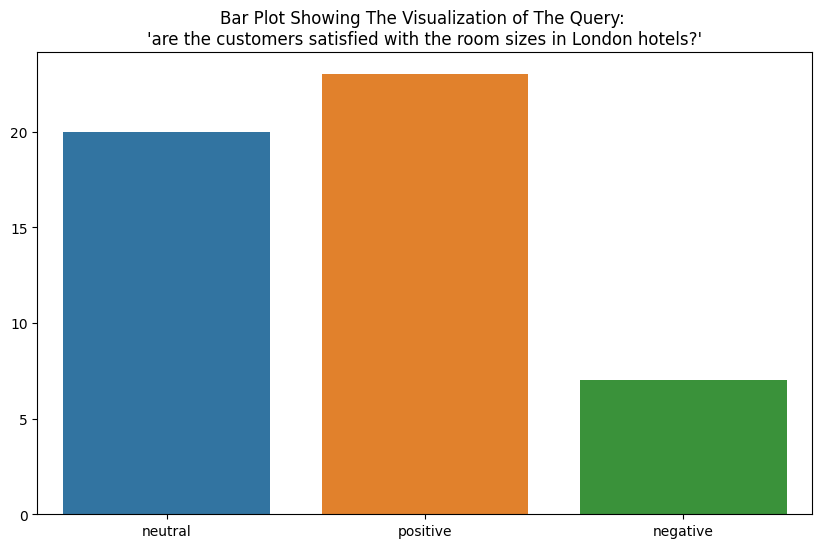

In [ ]:
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.barplot(x=list(sentiment.keys()), y=list(sentiment.values()))
plt.title(f"Bar Plot Showing The Visualization of The Query: \n{query!r}")
plt.show()

#### Comment

- The customers are generally satisfied with the room sizes, although many are still neutral and negative.


<hr><br><br>

### Filtering

- [Official Docs](https://qdrant.tech/documentation/concepts/filtering/)

#### More Analysis

- We can be even more specific when searching for reviews with the help of Pinecone's metadata filtering.
- For instance, we can specify a period in our query to ensure that search results only contain customer reviews for that period.
- This is helpful if you want to understand the customer's opinion during a specific period.

- Let's do this for the same query as before. We will filter reviews from 25th December to 31st December 2015.
- Previously we added the review_date field as a timestamp to the metadata during indexing.
- We can convert the start and end date of the period to timestamp using the get_timestamp function and use a `$gte` (greater than or equal to) and a `$lte` (less than or equal to) filter to get reviews from only the selected period.

In [ ]:
N: int = 3
# Generate timestamps for start and end time of the period
s_date, e_date = ["2015-10-16", "2017-10-01"]  # mm-dd-yyyy
start_time: float = get_timestamp([s_date])[0]
end_time: float = get_timestamp([e_date])[0]

query_filter: dict[str, Any] = {
    "must": [
        {"key": "timestamps", "range": {"gte": start_time, "lte": end_time}},
    ]
}


query: str = "bad room"
query_vector: list[float] = encoder.encode(query).tolist()
# query_filter: models.Filter = models.Filter(
#     must=[models.FieldCondition(key="year", range=models.Range(gte=2000))]
# )


hits: list[Any] = client.search(
    collection_name=COLLECTION_NAME,
    query_vector=query_vector,
    query_filter=query_filter,
    limit=N,
)
for hit in hits:
    print(hit.payload, "score:", hit.score)

In [ ]:
# Generate timestamps for start and end time of the period
s_date, e_date = ["2015-12-25", "2015-12-31"]
start_time: float = get_timestamp([s_date])[0]
end_time: float = get_timestamp([e_date])[0]

query: str = "are the customers satisified with the room sizes of hotels in London?"
# Generate query embeddings
enc_query: list[float] = retriever.encode(query).tolist()

# Query pinecone with query embeddings and the period filter
result = index.query(
    enc_query,
    top_k=N,
    include_metadata=True,
    filter={"timestamp": {"$gte": start_time, "$lte": end_time}},
)

# Get an overall count of customer sentiment
sentiment = count_sentiment(result)

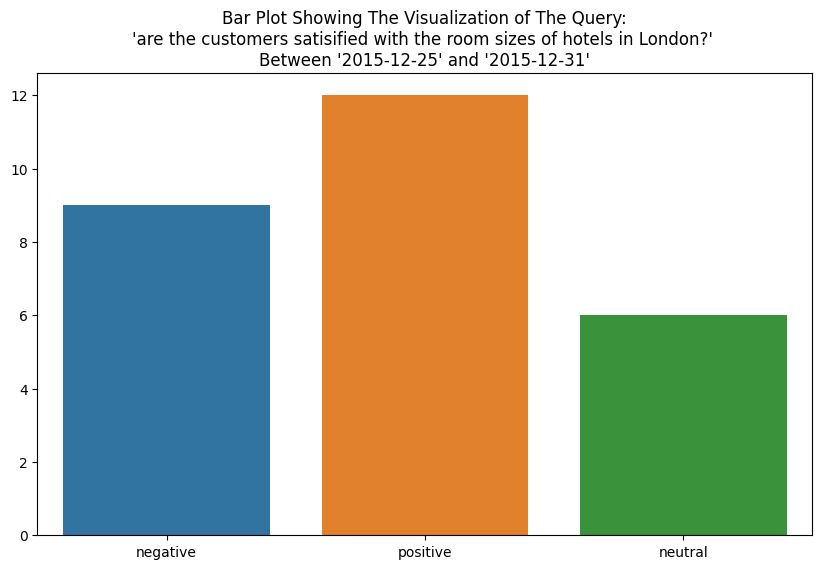

In [ ]:
# plot a barchart using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=list(sentiment.keys()), y=list(sentiment.values()))
text: str = (
    "Bar Plot Showing The Visualization of The Query:"
    + f"\n{query!r} \nBetween {s_date!r} and {e_date!r}"
)
plt.title(text)
plt.show()

In [ ]:
# Unique hotels
df_pl.select(pl.col("hotel_name")).unique().to_series().to_list()

['Park Grand London Kensington',
 'Park Plaza County Hall London',
 'Blakemore Hyde Park',
 'Strand Palace Hotel',
 'Hilton London Wembley',
 'Park Grand Paddington Court',
 'Grand Royale London Hyde Park',
 'St James Court A Taj Hotel London',
 'Hotel Da Vinci',
 'Copthorne Tara Hotel London Kensington',
 'Intercontinental London The O2',
 'M by Montcalm Shoreditch London Tech City',
 'Park Plaza Westminster Bridge London',
 'Britannia International Hotel Canary Wharf',
 'Park Plaza London Riverbank',
 'DoubleTree by Hilton London Docklands Riverside',
 'Holiday Inn London Kensington',
 'Hilton London Metropole',
 'Millennium Gloucester Hotel London',
 'DoubleTree by Hilton Hotel London Tower of London']

In [ ]:
# Generate timestamps for start and end time of the period
s_date, e_date = ["2015-12-25", "2015-12-31"]
start_time: float = get_timestamp([s_date])[0]
end_time: float = get_timestamp([e_date])[0]

query: str = "are the customers satisified with the food in Hyde Park?"
# Generate query embeddings
enc_query: list[float] = retriever.encode(query).tolist()

# Query pinecone with query embeddings and the period filter
result = index.query(
    enc_query,
    top_k=N,
    include_metadata=True,
    filter={"timestamp": {"$gte": start_time, "$lte": end_time}},
)

# Get an overall count of customer sentiment
sentiment = count_sentiment(result)

In [ ]:
result

{'matches': [{'id': '5846',
              'metadata': {'hotel_name': 'Grand Royale London Hyde Park',
                           'label': 'positive',
                           'review': ' The place has a very good location '
                                     'surroundEd by many facilities and well '
                                     'communicated The breakfast if booked '
                                     'early is worth Just one complain they '
                                     'could have natural orange juice ',
                           'review_date': datetime.date(2015, 12, 29),
                           'review_length': 182.0,
                           'score': 0.9624735713005066,
                           'timestamp': 1451347200.0},
              'score': 0.550751507,
              'values': []},
             {'id': '5848',
              'metadata': {'hotel_name': 'Grand Royale London Hyde Park',
                           'label': 'positive',
                   

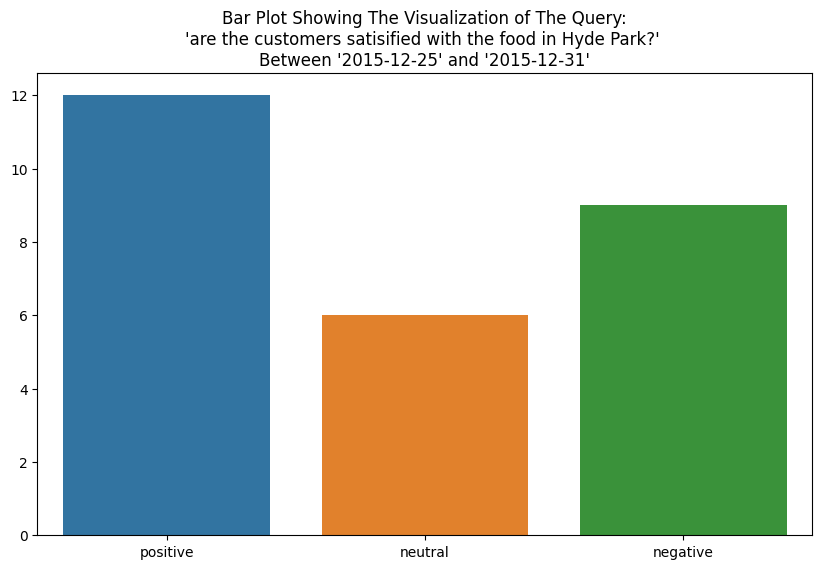

In [ ]:
# plot a barchart using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=list(sentiment.keys()), y=list(sentiment.values()))
text: str = (
    "Bar Plot Showing The Visualization of The Query:"
    + f"\n{query!r} \nBetween {s_date!r} and {e_date!r}"
)
plt.title(text)
plt.show()

In [ ]:
hotels: list[str] = [
    "Strand Palace Hotel",
    "Park Plaza County Hall London",
    "Grand Royale London Hyde Park",
    "Intercontinental London The O2",
]

### To Do

- We will look into five main areas:
  - Room Size
  - Cleanliness
  - Staff
  - Food
  - AC

- We have a query for each of these areas below.

In [ ]:
queries: dict[str, str] = {
    "Room Size": "are customers happy with the room sizes?",
    "Cleanliness": "are customers satisfied with the cleanliness of the rooms?",
    "Staff": "did the customers like how they were treated by the staff?",
    "Food": "did the customers enjoy the food?",
    "AC": "customer opinion on the AC",
}

In [ ]:
hotel_sentiments: list[Any] = []


# iterate through the hotels
for hotel in hotels:
    result = []
    # iterate through the keys and values in the queries dict
    for area, query in queries.items():
        # generate query embeddings
        xq = retriever.encode(query).tolist()
        # query pinecone with query embeddings and the hotel filter
        xc = index.query(
            xq, top_k=500, include_metadata=True, filter={"hotel_name": hotel}
        )
        # get an overall count of customer sentiment
        sentiment = count_sentiment(xc)
        # sort the sentiment to show area and each value side by side
        for k, v in sentiment.items():
            data = {"area": area, "label": k, "value": v}
            # add the data to result list
            result.append(data)
    # convert the
    hotel_sentiments.append({"hotel": hotel, "df": pl.DataFrame(result)})

In [ ]:
print(hotel_sentiments)

[
    {'hotel': 'Strand Palace Hotel', 'df': shape: (0, 0)
┌┐
╞╡
└┘},
    {
        'hotel': 'Park Plaza County Hall London',
        'df': shape: (15, 3)
┌─────────────┬──────────┬───────┐
│ area        ┆ label    ┆ value │
│ ---         ┆ ---      ┆ ---   │
│ str         ┆ str      ┆ i64   │
╞═════════════╪══════════╪═══════╡
│ Room Size   ┆ neutral  ┆ 65    │
│ Room Size   ┆ negative ┆ 55    │
│ Room Size   ┆ positive ┆ 380   │
│ Cleanliness ┆ positive ┆ 384   │
│ …           ┆ …        ┆ …     │
│ Food        ┆ neutral  ┆ 61    │
│ AC          ┆ negative ┆ 110   │
│ AC          ┆ neutral  ┆ 44    │
│ AC          ┆ positive ┆ 346   │
└─────────────┴──────────┴───────┘
    },
    {
        'hotel': 'Grand Royale London Hyde Park',
        'df': shape: (15, 3)
┌─────────────┬──────────┬───────┐
│ area        ┆ label    ┆ value │
│ ---         ┆ ---      ┆ ---   │
│ str         ┆ str      ┆ i64   │
╞═════════════╪══════════╪═══════╡
│ Room Size   ┆ neutral  ┆ 248   │
│ Room Size   ┆ positive ┆ 121   │
│ Room Size   ┆ negative ┆ 131   │
│ Cleanliness ┆ positive ┆ 300   │
│ …           ┆ …        ┆ …     │
│ Food        ┆ neutral  ┆ 32    │
│ AC          ┆ positive ┆ 333   │
│ AC          ┆ negative ┆ 129   │
│ AC          ┆ neutral  ┆ 38    │
└─────────────┴──────────┴───────┘
    },
    {'hotel': 'Intercontinental London The O2', 'df': shape: (0, 0)
┌┐
╞╡
└┘}
]

In [ ]:
hotel_sentiments[0]["df"]

""
